# World Wide Products Inc.
## General Info
Author: Patrick McNamee

Date: 10/2/2019

## Description
Using a [dataset](https://www.kaggle.com/felixzhao/productdemandforecasting) from Kaggle to attempt to forcast product demand for an anonymous product.

## Data Acquisition and Cleaning
First thing to do is load in the original data set and take a look

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r'./data/Historical Product Demand.csv')
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


The most numerous ordered product is Product_1359 according to Kaggle and so I will look only at that product.

In [3]:
df = df.loc[df['Product_Code'] == 'Product_1359']
df = df.reset_index(drop=True)
df.tail()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
16931,Product_1359,Whse_J,Category_019,2016/10/3,20000
16932,Product_1359,Whse_J,Category_019,2016/9/16,10000
16933,Product_1359,Whse_J,Category_019,2016/11/1,30000
16934,Product_1359,Whse_J,Category_019,2016/12/1,20000
16935,Product_1359,Whse_J,Category_019,2016/12/9,20000


So Product_1359 has been isolated although it has a lot of entries but we are still seeing the same values for the Product_Category as well as Warehouse. I will check to see if there are multiple unique values in these columns. If there is only one value, I will remove them as there is no additional information from those columns.

In [4]:
print(df['Warehouse'].unique())

['Whse_J']


In [5]:
print(df['Product_Category'].unique())

['Category_019']


In [6]:
df = df.drop(['Product_Code', 'Warehouse', 'Product_Category'], axis=1)

There is no NaNs in the dataframe as it would show up in the lists of unique values. I will commit this data to a csv for easier access later on. However, first I need to do some type conversion to numerically manipulate the information.

In [7]:
df['Date'] = pd.to_datetime(df['Date'])#converting over to date time

In [8]:
df['Order_Demand'].unique()

array(['80000 ', '70000 ', '100000 ', '84000 ', '1000 ', '15000 ',
       '30000 ', '10000 ', '28000 ', '5000 ', '6000 ', '21000 ', '2000 ',
       '3000 ', '50000 ', '75000 ', '20000 ', '750000 ', '225000 ',
       '300000 ', '150000 ', '525000 ', '375000 ', '11000 ', '14000 ',
       '39000 ', '25000 ', '12000 ', '35000 ', '13000 ', '60000 ',
       '7000 ', '34000 ', '8000 ', '9000 ', '36000 ', '16000 ', '18000 ',
       '4000 ', '17000 ', '56000 ', '54000 ', '63000 ', '85000 ',
       '37000 ', '65000 ', '59000 ', '66000 ', '72000 ', '43000 ',
       '51000 ', '134000 ', '61000 ', '155000 ', '74000 ', '266000 ',
       '88000 ', '90000 ', '223000 ', '120000 ', '101000 ', '139000 ',
       '222000 ', '26000 ', '121000 ', '27000 ', '234000 ', '149000 ',
       '118000 ', '98000 ', '78000 ', '52000 ', '200000 ', '40000 ',
       '400000 ', '1000000 ', '700000 ', '740000 ', '130000 ', '500000 ',
       '550000 ', '19000 ', '22000 ', '112000 ', '105000 ', '29000 ',
       '31000 ', '450

In [9]:
#Loop to remove parenthesis from numbers
for i in range(len(df)):
    date = df.iat[i, 1]
    if date[0] == '(':
        date = date[1:-2]
        df.iat[i,1] = date
#Type conversion to int
df['Order_Demand'] = df['Order_Demand'].astype('int32')
df['Order_Demand'].unique()

array([  80000,   70000,  100000,   84000,    1000,   15000,   30000,
         10000,   28000,    5000,    6000,   21000,    2000,    3000,
         50000,   75000,   20000,  750000,  225000,  300000,  150000,
        525000,  375000,   11000,   14000,   39000,   25000,   12000,
         35000,   13000,   60000,    7000,   34000,    8000,    9000,
         36000,   16000,   18000,    4000,   17000,   56000,   54000,
         63000,   85000,   37000,   65000,   59000,   66000,   72000,
         43000,   51000,  134000,   61000,  155000,   74000,  266000,
         88000,   90000,  223000,  120000,  101000,  139000,  222000,
         26000,  121000,   27000,  234000,  149000,  118000,   98000,
         78000,   52000,  200000,   40000,  400000, 1000000,  700000,
        740000,  130000,  500000,  550000,   19000,   22000,  112000,
        105000,   29000,   31000,   45000,   49000,   24000,  104000,
         41000,   58000,  144000,   38000,   32000,   86000,   64000,
         82000,   33

## Preliminary Exploration

Alright, lets take a look at some possible binnings to determine what is an appropriate time scale for product demand.

In [10]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11, 4)})

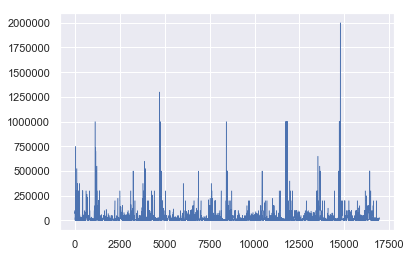

In [11]:
df['Order_Demand'].plot(linewidth=0.5)

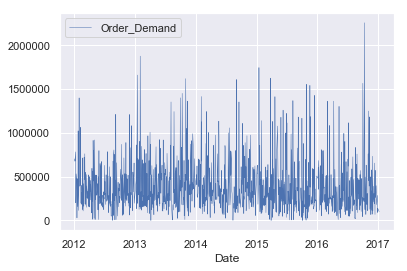

In [12]:
daily_orders = df.groupby(df['Date'].dt.date).sum()
daily_orders.plot(linewidth=0.5)

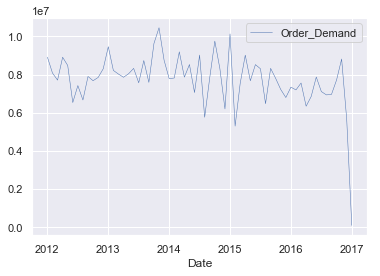

In [13]:
period = df.Date.dt.to_period("M")
monthly_orders = df.groupby(period).sum()
monthly_orders.plot(linewidth=0.5)

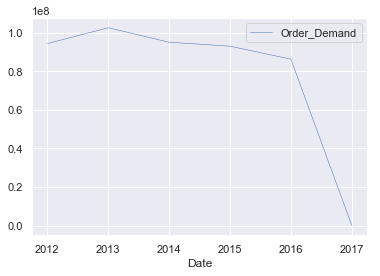

In [14]:
period = df.Date.dt.to_period("Y")
yearly_orders = df.groupby(period).sum()
yearly_orders.plot(linewidth=0.5)

So there are multiple orders per day although some days have zero orders. It happens to be quite noisely on the day-by-day level. Monthly and yearly trends are significantly better.

## Model Building
### Testing
I'll use the year 2016 as a testing set and 2012 to 2015 as the training set. This will give a rough 80-20 train-test split for some model comparisons.

In [15]:
#Using weekly orders as minimum window otherwise we have negative orders
weekly_orders = df.groupby(pd.Grouper(key='Date', freq='W-MON')).sum().reset_index()

training = weekly_orders.loc[weekly_orders['Date'] <
                            pd.to_datetime('2016-1-1').date()]
testing = weekly_orders.loc[weekly_orders['Date'] >
                            pd.to_datetime('2015-12-31').date()]

### Prophet

Prophet is something Facebook published for time series forecasting and so I'll start with that.

In [16]:
from fbprophet import Prophet as pt

prophet_model = pt(interval_width=0.95)

In [17]:
#required specific column headings
training_renamed = training.rename(columns={'Date': 'ds', 'Order_Demand': 'y'})
testing_renamed = testing.rename(columns={'Date': 'ds', 'Order_Demand': 'y'})

prophet_model.fit(training_renamed)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [18]:
testing_dates = prophet_model.make_future_dataframe(periods=16, freq='MS')

testing_dates.tail()

,ds
219,2016-12-01
220,2017-01-01
221,2017-02-01
222,2017-03-01
223,2017-04-01


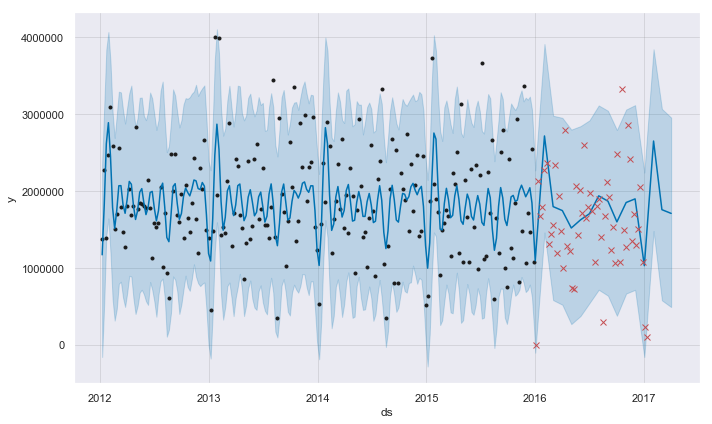

In [19]:
import matplotlib.pyplot as plt

forecast = prophet_model.predict(testing_dates)
prophet_model.plot(forecast, uncertainty=True)

ax = plt.gca()
ax.plot(testing['Date'], testing['Order_Demand'], 'rx')#Test Points

Aside from the strict naming convention, Prophet is fairly easy to use. The only trouble is determining what timeframe to bin everything. The prediction from the model are shown in the graph above. The predicted value is given by the blue line with a 95% uncertainty region shwon by the blue area. The training points are the black dots and the testing points are the red x's. Overall the model gave a fairly good band for forcasting although the data is so noisy that is not hard to do with such a large varaince. The components of the forecast are shown in the plots below and the yearly trend appears to indicate an overall slowdown of product sales while variance within the year is highly sinoisodal.

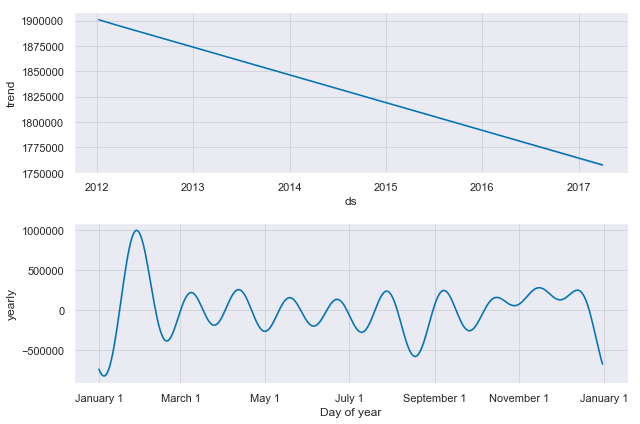

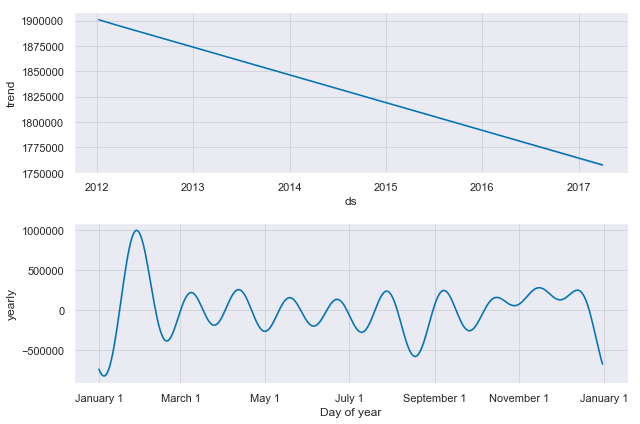

In [20]:
prophet_model.plot_components(forecast)

### ARIMA

ARIMA is a autoregressive (AR), integrative (I), moving average (MA) model used in forecasting. The model is a linear model that is dependent on the previous values (AR part), the difference between values (I part), and an average of past noise (MA part). I'll be following the procedures given in this [blog post](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/) for this data set and see if it preforms better than the Prophet model.

The first step is to use the Augmented Dickey Fuller (ADF) test to determine if differencing is needed. 

In [24]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(training['Order_Demand'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.491296
p-value: 0.000204


### ~~ARIMA~~ ARMA
So the ADF statistic indicates that the series is stationary since the p-value is less than 0.05 and so we need no differencing. Hence we drop the integrative portion of the model and instead just use the autoregressive and moving average portions.

Next thing to do is look at the partial autocorrelation (PACF) plot.

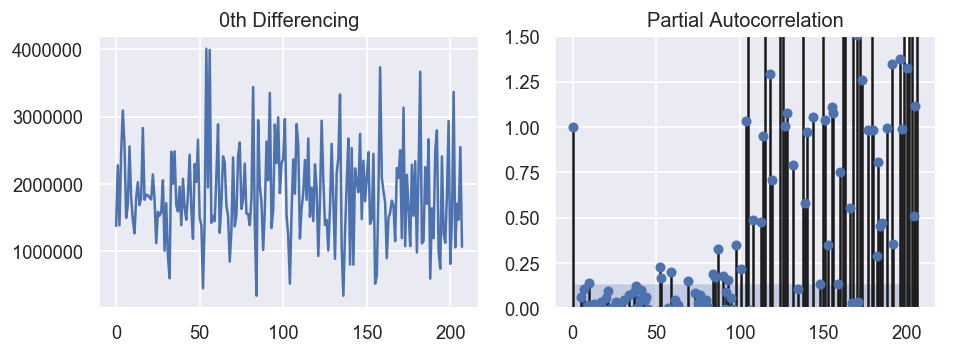

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(training.Order_Demand)
axes[0].set_title('0th Differencing')
axes[1].set(ylim=(0,1.5))
plot_pacf(training['Order_Demand'], ax=axes[1])

plt.show()

So the third lag is significant but there appears not to be any other signicant lags. Thus we only need 3 autoregressive term.

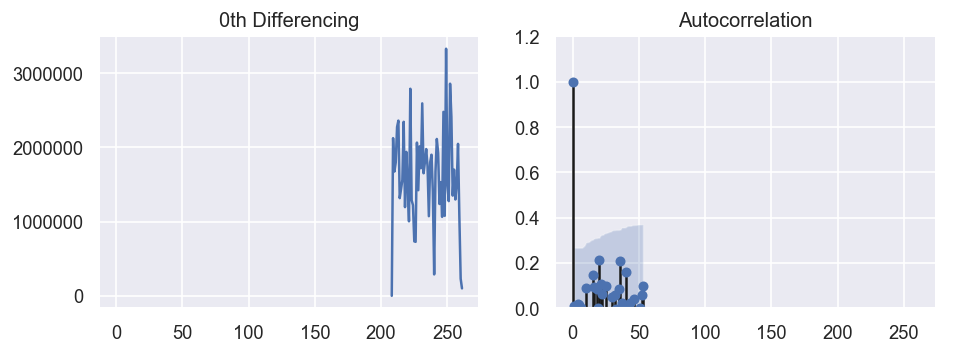

In [30]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(testing['Order_Demand'])
axes[0].set_title('0th Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(testing['Order_Demand'], ax=axes[1])

plt.show()

So from the autocorrelation, it appears that we do not need any moving average terms aside from the average. So with the numbers of p = 3 (AR), d = 0 (I), and q = 0 (MA) we can build the model.

In [46]:
from statsmodels.tsa.arima_model import ARIMA

# 0,3,0 ARIMA Model
ARIMA_model = ARIMA(training['Order_Demand'], order=(3,0,0))
ARIMA_model_fit = ARIMA_model.fit(disp=0)
print(ARIMA_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:           Order_Demand   No. Observations:                  208
Model:                     ARMA(3, 0)   Log Likelihood               -3086.792
Method:                       css-mle   S.D. of innovations         674104.028
Date:                Thu, 24 Oct 2019   AIC                           6183.584
Time:                        00:40:03   BIC                           6200.271
Sample:                             0   HQIC                          6190.331
                                                                              
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.852e+06   3.38e+04     54.744      0.000    1.79e+06    1.92e+06
ar.L1.Order_Demand    -0.0808      0.069     -1.173      0.242      -0.216       0.054
ar.L2.Order_Demand  

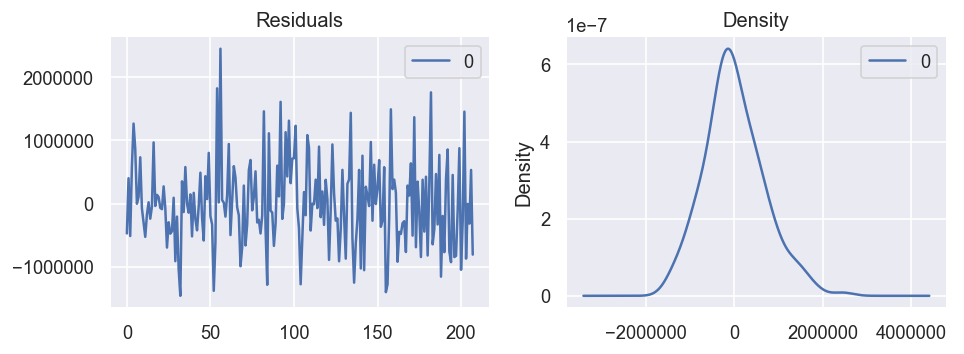

In [47]:
residuals = pd.DataFrame(ARIMA_model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

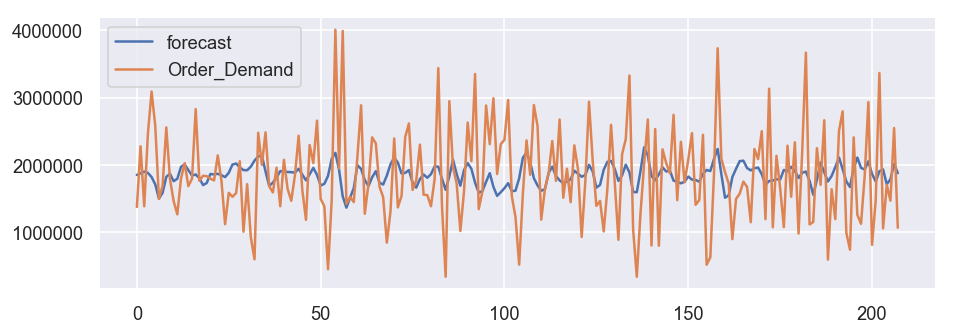

In [49]:
ARIMA_model_fit.plot_predict(dynamic=False)
plt.show()

The above is graphs show the residuals and the estimated values of the training data. The density of the residuals is not a terrible shape but from the estimated value plot, you can see that there is a lot of noise if the product ordering.

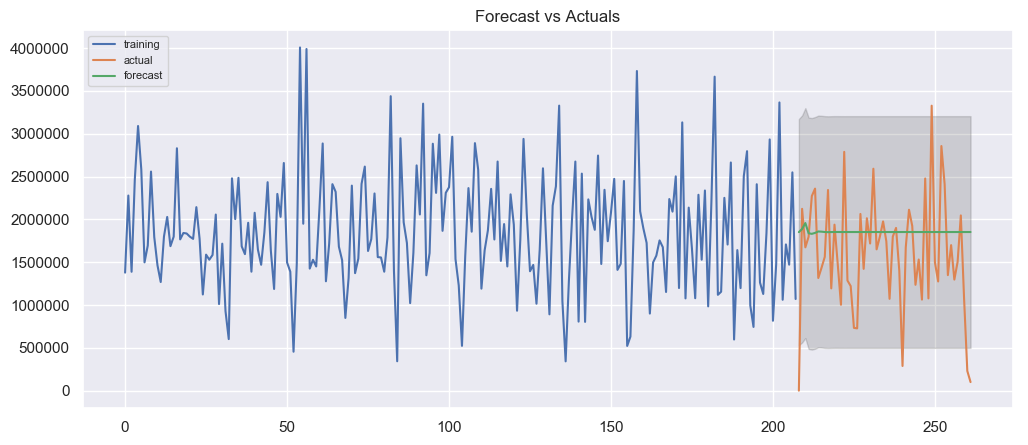

In [55]:
# Forecast
fc, se, conf = ARIMA_model_fit.forecast(54, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=testing.index)
lower_series = pd.Series(conf[:, 0], index=testing.index)
upper_series = pd.Series(conf[:, 1], index=testing.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(training['Order_Demand'], label='training')
plt.plot(testing['Order_Demand'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Conclusions
Two forecasting models were created for forcasting weekly demand of Product_1359, a Prophet model and an ARMA model. It appears that the demand is extremely noisy on a weekly level and so perphaps on a biweekly or monthly level the models would have better predictions. There was some problems with Prophet model as it is starting to get too large of a timeframe for it to effectively break down components. However, between the two models, the Prophet one currently preforms better.